In [1]:
import numpy as np
from scipy.io import savemat,loadmat
import torchvision.transforms as transforms
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns


C:\Users\2357638D\.conda\envs\pytorch\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 126] The specified module could not be found
  warn(f"Failed to load image Python extension: {e}")


In [52]:
path = 's1_db2_response960_exB.mat'
signal = loadmat(path)
spike = signal['spike']
label = signal['label']

In [35]:
sub = 1
in_fea = 48
path = 's'+str(sub)+'_db2_exB_SNR10.mat'
signal = loadmat(path)
spike1 = signal['s_spk']
label1 = signal['s_label']
path = 's'+str(sub)+'_db2_exC_SNR10.mat'
signal = loadmat(path)
spike2 = signal['s_spk']
label2 = signal['s_label']
path = 's'+str(sub)+'_db2_exD_SNR10.mat'
signal = loadmat(path)
spike3= signal['s_spk']
label3 = signal['s_label']
path = 's'+str(sub)+'_db2_rest_SNR10.mat'
signal = loadmat(path)
spike4= signal['s_rest']
label4 = signal['s_rest_label']
spike = np.concatenate((spike4,spike1,spike2,spike3),axis=0)
label = np.concatenate((label4,label1,label2,label3),axis=0)

In [2]:
sub = 1
in_fea = 480
path = 's'+str(sub)+'_db2_response480_exB_SNR30.mat'
signal = loadmat(path)
spike1 = signal['spike']
label1 = signal['label']
path = 's'+str(sub)+'_db2_response480_exC_SNR30.mat'
signal = loadmat(path)
spike2 = signal['spike']
label2 = signal['label']
path = 's'+str(sub)+'_db2_response480_exD_SNR30.mat'
signal = loadmat(path)
spike3 = signal['spike']
label3 = signal['label']
path = 's'+str(sub)+'_db2_response480_rest_SNR30.mat'
signal = loadmat(path)
spike4 = signal['spike']
label4 = signal['label']
spike = np.concatenate((spike4,spike1,spike2,spike3),axis=0)
label = np.concatenate((label4,label1,label2,label3),axis=0)

In [3]:
sub = 33
in_fea = 144
path = 's'+str(sub)+'_db2_response'+str(in_fea)+'_exD.mat'
signal = loadmat(path)
spike = signal['spike']
label = signal['label']

In [3]:
print(spike.shape)

(1200, 400, 480)


In [4]:
num_sample =label.shape[0]
num_classes = 50 
new_label = np.zeros(num_sample)
#for i in range(num_sample):
#    new_label[i] = int(label[i,0])
for i in range(num_sample):
    new_label[i] = int(label[i,0]) 

In [5]:
print(new_label)

[ 0.  0.  0. ... 49. 49. 49.]


In [6]:
'''apply a window to bin the signal'''
'''along neuron axis'''
def bin_signal(window_size, signal,step_size):
    bins = []
    
    for i in range(0, len(signal) - window_size + 1,step_size):
        window = signal[i:i + window_size,:]
        val = np.sum(window, axis=0)
        bins.append(val)
        
    bins = np.array(bins)

    return bins

window_size = 400
step_size = 400
fea_len = int(400/window_size)

In [10]:
'''input spikes (40 features)'''
feature_map = np.zeros((num_sample,fea_len,48))
for i in range(num_sample):
    x = bin_signal(window_size,spike[i,0],step_size)
    feature_map[i,:,:] = x

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [7]:
'''output spikes (400 features)'''
feature_map = np.zeros((num_sample,fea_len,in_fea))
for i in range(num_sample):
    x = bin_signal(window_size,spike[i,:,:],step_size)
    feature_map[i,:,:] = x

In [8]:
#X = np.reshape(feature_map,(192,1,960))
X = feature_map
Y = new_label
X = X.squeeze()
Y = Y.squeeze()
Y = Y.astype(int)
print(X.shape)
print(Y.shape)

(1200, 480)
(1200,)


In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,Y, test_size=.2, random_state=10)
y_train_one_hot = np.eye(num_classes)[y_train]

In [41]:
num_features = in_fea  # Input features
   # Number of output classes

weights = np.random.randn(num_features, num_classes) * 0.01
biases = np.zeros(num_classes)

learning_rate = 0.005
epochs = 200

In [42]:
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / exp_z.sum(axis=1, keepdims=True)

def predict(X, weights, biases):
    linear_output = np.dot(X, weights) + biases
    probabilities = softmax(linear_output)
    return np.argmax(probabilities, axis=1)


# Training loop
epoch_lst = []
loss_lst = []
acc_test_lst = []
acc_train_lst = []
for epoch in range(epochs):
    # Forward pass
    linear_output = np.dot(X_train, weights) + biases
    output = softmax(linear_output)
    
    # Compute the error
    error = y_train_one_hot - output
    
    # Weight and bias updates
    weights += learning_rate * np.dot(X_train.T, error)
    biases += learning_rate * error.sum(axis=0)
    
    # Compute the loss (cross-entropy)
    loss = -np.mean(np.sum(y_train_one_hot * np.log(output + 1e-9), axis=1))
    
    # Print the loss every epoch
    test_predictions = predict(X_test, weights, biases)
    train_predictions = predict(X_train, weights, biases)
    accuracy_test = (test_predictions == y_test).sum() / y_test.shape[0]
    accuracy_train = (train_predictions == y_train).sum() / y_train.shape[0]
    
    epoch_lst.append(epoch)
    loss_lst.append(loss)
    acc_test_lst.append(accuracy_test)
    acc_train_lst.append(accuracy_train)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}')

print("Training complete.")

Epoch 10/200, Loss: 2.8726
Epoch 20/200, Loss: 1.4022
Epoch 30/200, Loss: 0.8699
Epoch 40/200, Loss: 0.8300
Epoch 50/200, Loss: 0.6375
Epoch 60/200, Loss: 0.4989
Epoch 70/200, Loss: 0.4386
Epoch 80/200, Loss: 0.3435
Epoch 90/200, Loss: 0.3695
Epoch 100/200, Loss: 0.3682
Epoch 110/200, Loss: 0.2091
Epoch 120/200, Loss: 0.3631
Epoch 130/200, Loss: 0.2448
Epoch 140/200, Loss: 0.2812
Epoch 150/200, Loss: 0.3172
Epoch 160/200, Loss: 0.2860
Epoch 170/200, Loss: 0.2985
Epoch 180/200, Loss: 0.2194
Epoch 190/200, Loss: 0.2666
Epoch 200/200, Loss: 0.1727
Training complete.


Text(0.5, 0, 'epoch')

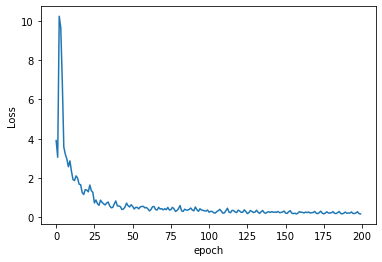

In [43]:
plt.plot(epoch_lst,loss_lst)
plt.ylabel('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

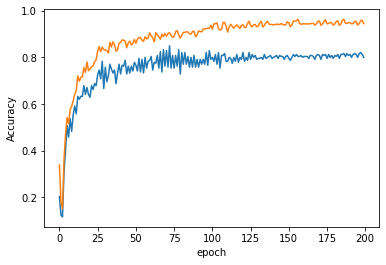

In [44]:
plt.plot(epoch_lst,acc_test_lst,acc_train_lst)
plt.ylabel('Accuracy')
plt.xlabel('epoch')

In [45]:
y_pred = test_predictions
cm = confusion_matrix(y_test, y_pred, labels=range(num_classes))
sensitivity = np.zeros(num_classes)
specificity = np.zeros(num_classes)
precision = np.zeros(num_classes)
f1_score = np.zeros(num_classes)

for i in range(num_classes):
    TP = cm[i, i]  # True Positives for class i
    FP = cm[:, i].sum() - TP  # False Positives for class i
    FN = cm[i, :].sum() - TP  # False Negatives for class i
    TN = cm.sum() - (FP + FN + TP)  # True Negatives for class i

    sensitivity[i] = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity[i] = TN / (TN + FP) if (TN + FP) != 0 else 0
    precision[i] = TP / (TP + FP) if (TP + FP) != 0 else 0
    f1_score[i] = 2 * precision[i] * sensitivity[i] / (precision[i] + sensitivity[i]) if (precision[i] + sensitivity[i]) != 0 else 0
    


overall_sensitivity_macro = np.mean(sensitivity)
overall_specificity_macro = np.mean(specificity)
overall_precision_macro = np.mean(precision)
overall_f1_macro = np.mean(f1_score) 

# Print results
print(f"Overall Accuracy Macro-Averaged: {accuracy_test:.3f}")
print(f"Overall Precision Macro-Averaged: {overall_precision_macro:.3f}")
print(f"Overall Specificity Macro-Averaged: {overall_specificity_macro:.3f}")
print(f"Overall f1 Macro-Averaged: {overall_f1_macro:.3f}")
print(f"Overall Sensitivity (Recall) Macro-Averaged: {overall_sensitivity_macro:.3f}")




Overall Accuracy Macro-Averaged: 0.800
Overall Precision Macro-Averaged: 0.787
Overall Specificity Macro-Averaged: 0.996
Overall f1 Macro-Averaged: 0.772
Overall Sensitivity (Recall) Macro-Averaged: 0.800


Confusion Matrix:
[[7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 5 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 5 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 4 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5]]


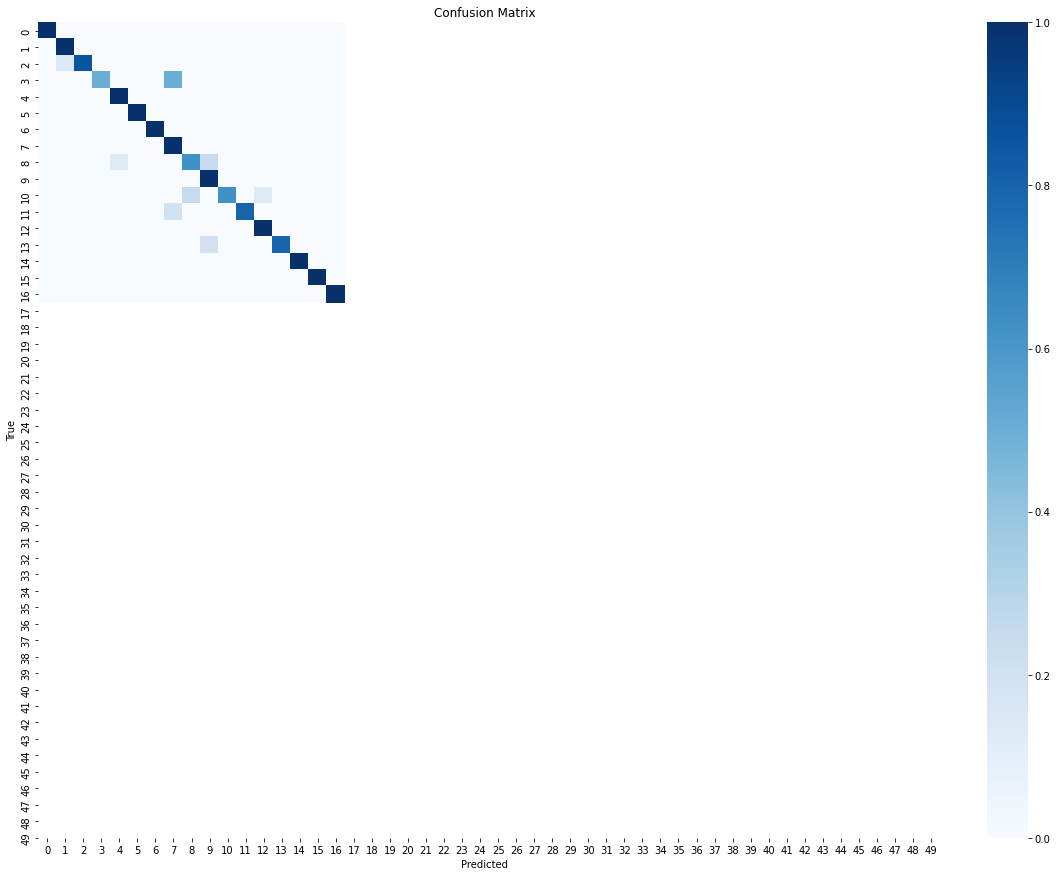

In [137]:
# Plot the confusion matrix
# Confusion Matrix
y_pred = test_predictions
cm = confusion_matrix(y_test, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(20, 15))

sns.heatmap(cm_percentage, annot=False, fmt='.1f', cmap='Blues', xticklabels=[i for i in range(0,50)], yticklabels=[i for i in range(0,50)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [541]:
y_pred = test_predictions
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.60      1.00      0.75         3
           2       1.00      0.86      0.92         7
           3       0.62      1.00      0.77         5
           4       0.50      1.00      0.67         5
           5       1.00      0.20      0.33         5
           6       1.00      0.50      0.67         4
           7       0.67      0.80      0.73         5
           8       0.86      1.00      0.92         6
           9       1.00      1.00      1.00         4
          10       1.00      1.00      1.00         5
          11       1.00      0.83      0.91         6
          12       0.67      0.75      0.71         8
          13       1.00      0.62      0.77         8
          14       0.50      0.40      0.44         5
          15       0.55      0.86      0.67         7
          16       0.67      1.00      0.80         2
          17       0.80    

C:\Users\2357638D\.conda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\2357638D\.conda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\2357638D\.conda\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [491]:
print(max(acc_test_lst))
print(max(acc_train_lst))

0.8458333333333333
0.9708333333333333


In [478]:
file_path = 'cm'+str(sub)+'.mat'
data = {'y_pred': test_predictions,'y_test': y_test } 
savemat(file_path, data)